# Hierarchical Reconciliation

When trying to forecast time series of a hierarchical nature, such as product hierarchies or nested temporal models, a large challenge is getting forecasts at different levels of the hierarchy to reconcile with one another. For instance, let's say we want to forecast sales for a company that carries 2 product categories, and 3 products within each category, as shown below:

<img src = 'images/product_hierarchy.png'>

We want to generate independent forecasts for each product, each category, and overall **and** we want the sum of our forecasts at the product level to equal the our total sales forecast for the company.

Prior methods of approaching hierarchical forecasting include bottom-up, top-down, and middle-out forecasting.

#### Bottom-Up

Start by forecasting the bottom levels of the hierarchy and then aggregate the forecasts up until you reach a top-level forecast. The drawbacks to bottom-up are that your forecasts for products with relatively little data will have a lot of uncertainty and that you will have trouble reconciling your bottom-level forecasts to your top-level forecast.

#### Top-Down

Start by forecasting the top-level forecast and use historical proportions for the next lowest level (in this case Category) to generate forecasts for the next level. Because proportions can vary so much over time, these models don't tend to do well in forecasting the bottom-level of your hierarchy.

#### Hierarchical Reconcilation

Hierarhical reconciliation attempts to address the drawbacks of bottom-up and top-down forecasting methodologies by using a weighted average approach. This has many benefits:
 - Uses more information within a hierarchy than other methods
 - Allows for correlations and interactions between series at each level in a hierarchy
 - Accounts for ad-hoc adjustments of forecasts at any level
 - Produced unbiased forecasts
 
The main drawbacks of this approach are:
 - Computation of the weights for these approaches can be expensive
 - It's not currently possible to compute prediction intervals for these models - we can only get point forecasts
 
Let's implement a hierarchically reconciled model in R!

# Load Packages

In [311]:
#install.packages('hts')
#install.packages('fpp2', dependencies = TRUE)
#install.packages('tsibble')
#install.packages('TSstudio')

In [312]:
library(fpp2)
library(forecast)
library(hts)
library(tidyverse)
library(gridExtra)
library(tsibble)
library(repr)
library(TSstudio)

# Inspect Data

In [313]:
head(visnights)

,NSWMetro,NSWNthCo,NSWSthCo,NSWSthIn,NSWNthIn,QLDMetro,QLDCntrl,QLDNthCo,SAUMetro,SAUCoast,SAUInner,VICMetro,VICWstCo,VICEstCo,VICInner,WAUMetro,WAUCoast,WAUInner,OTHMetro,OTHNoMet
1998 Q1,9.047095,8.565678,5.818029,2.679538,2.977507,12.106052,2.748374,2.137234,2.881372,2.591997,0.8948773,7.490382,2.4420048,3.381972,5.326655,3.075779,3.066555,0.6949954,3.437924,2.073469
1998 Q2,6.962126,7.124468,2.466437,3.010732,3.477703,7.786687,4.040915,2.269596,2.124736,1.375780,0.9792509,5.198178,0.9605047,1.827940,4.441119,2.154929,3.334405,0.5576796,2.677081,1.787939
1998 Q3,6.871963,4.716893,1.928053,3.328869,3.014770,11.380024,5.343964,4.890227,2.284870,1.079542,0.9803289,5.244217,0.7559744,1.351952,3.815645,2.787286,4.365844,1.0061844,3.793743,2.345021
1998 Q4,7.147293,6.269299,2.797556,2.417772,3.757972,9.311460,4.260419,2.621548,1.785889,1.497664,1.5094343,6.274246,1.2716040,1.493415,3.859567,2.752910,4.521996,1.1725514,3.304231,1.943689
1999 Q1,7.956923,9.493901,4.853681,3.224285,3.790760,12.671942,4.186113,2.483203,2.293873,2.247684,0.9635227,9.187422,2.3850583,2.896929,4.588755,3.519564,3.579347,0.3981829,3.510819,2.165838
1999 Q2,6.542243,5.401201,2.759843,2.428489,3.395284,9.582965,4.237806,3.377830,2.197418,1.672802,0.9968803,4.992303,1.3288638,1.547901,4.070401,3.160430,3.408533,0.5960182,2.871867,1.803940


In [314]:
tail(visnights)

,NSWMetro,NSWNthCo,NSWSthCo,NSWSthIn,NSWNthIn,QLDMetro,QLDCntrl,QLDNthCo,SAUMetro,SAUCoast,SAUInner,VICMetro,VICWstCo,VICEstCo,VICInner,WAUMetro,WAUCoast,WAUInner,OTHMetro,OTHNoMet
2015 Q3,6.294490,5.486429,2.097544,3.079726,2.877699,10.740806,6.155201,6.530297,1.911144,0.996588,1.0210521,6.545236,0.8112797,1.1358062,4.569014,2.922297,6.347613,1.088081,4.419011,1.819066
2015 Q4,6.945476,6.818165,2.561440,2.630874,3.776077,10.300925,4.449971,3.637882,2.383107,1.972753,1.2512836,7.724151,1.5260334,1.8311882,4.584000,3.640983,6.174618,1.306545,3.809973,2.379368
2016 Q1,7.373757,9.945415,4.789194,2.767853,2.871376,11.875199,4.498251,3.127780,2.874414,2.860267,1.1136515,9.972275,2.4951023,3.2038931,5.762570,4.169990,6.738586,1.033123,4.288449,2.853101
2016 Q2,6.792234,6.664099,2.320229,2.691365,3.928462,9.058698,4.867572,3.658800,2.075967,1.680254,1.4646183,7.184241,0.9304271,1.2493981,4.382705,3.262924,5.937479,1.243278,3.278023,1.917090
2016 Q3,6.530568,5.978458,1.651091,3.269565,3.514431,11.236115,6.434020,5.359851,2.121646,1.554085,1.3354876,6.909728,0.9411218,0.9678755,4.285911,2.837998,6.065808,1.169328,4.290925,2.131902
2016 Q4,7.878277,7.362045,2.713210,2.739392,3.490721,12.057719,6.572584,3.302716,2.407233,1.705153,0.9250705,8.012161,1.3520852,1.7666327,4.955138,3.367659,5.983870,1.345384,4.233838,2.015250


In [315]:
dim(visnights)

[1] 76 20

Overall, we have 20 time series of distinct zone-state combinations at the lowest level, and 76 quarters of visitor data per zone-state combination. This data ranges from 1998 to 2016. 

# Import Data

We can convert this data into a hierarchical time series with the `hts` package. We provide the time series data to the `hts` function. We can also specify the nature of the hierarchy by providing information about the column names. The first 3 characters in each column indicate the state and the next 5 characters indicate the zones within each state.

In [316]:
tourism.hts <- hts(visnights, characters = c(3, 5))

### Plot the State level trends

In [317]:
#Resize the window in R
options(repr.plot.width = 40, repr.plot.height=17)

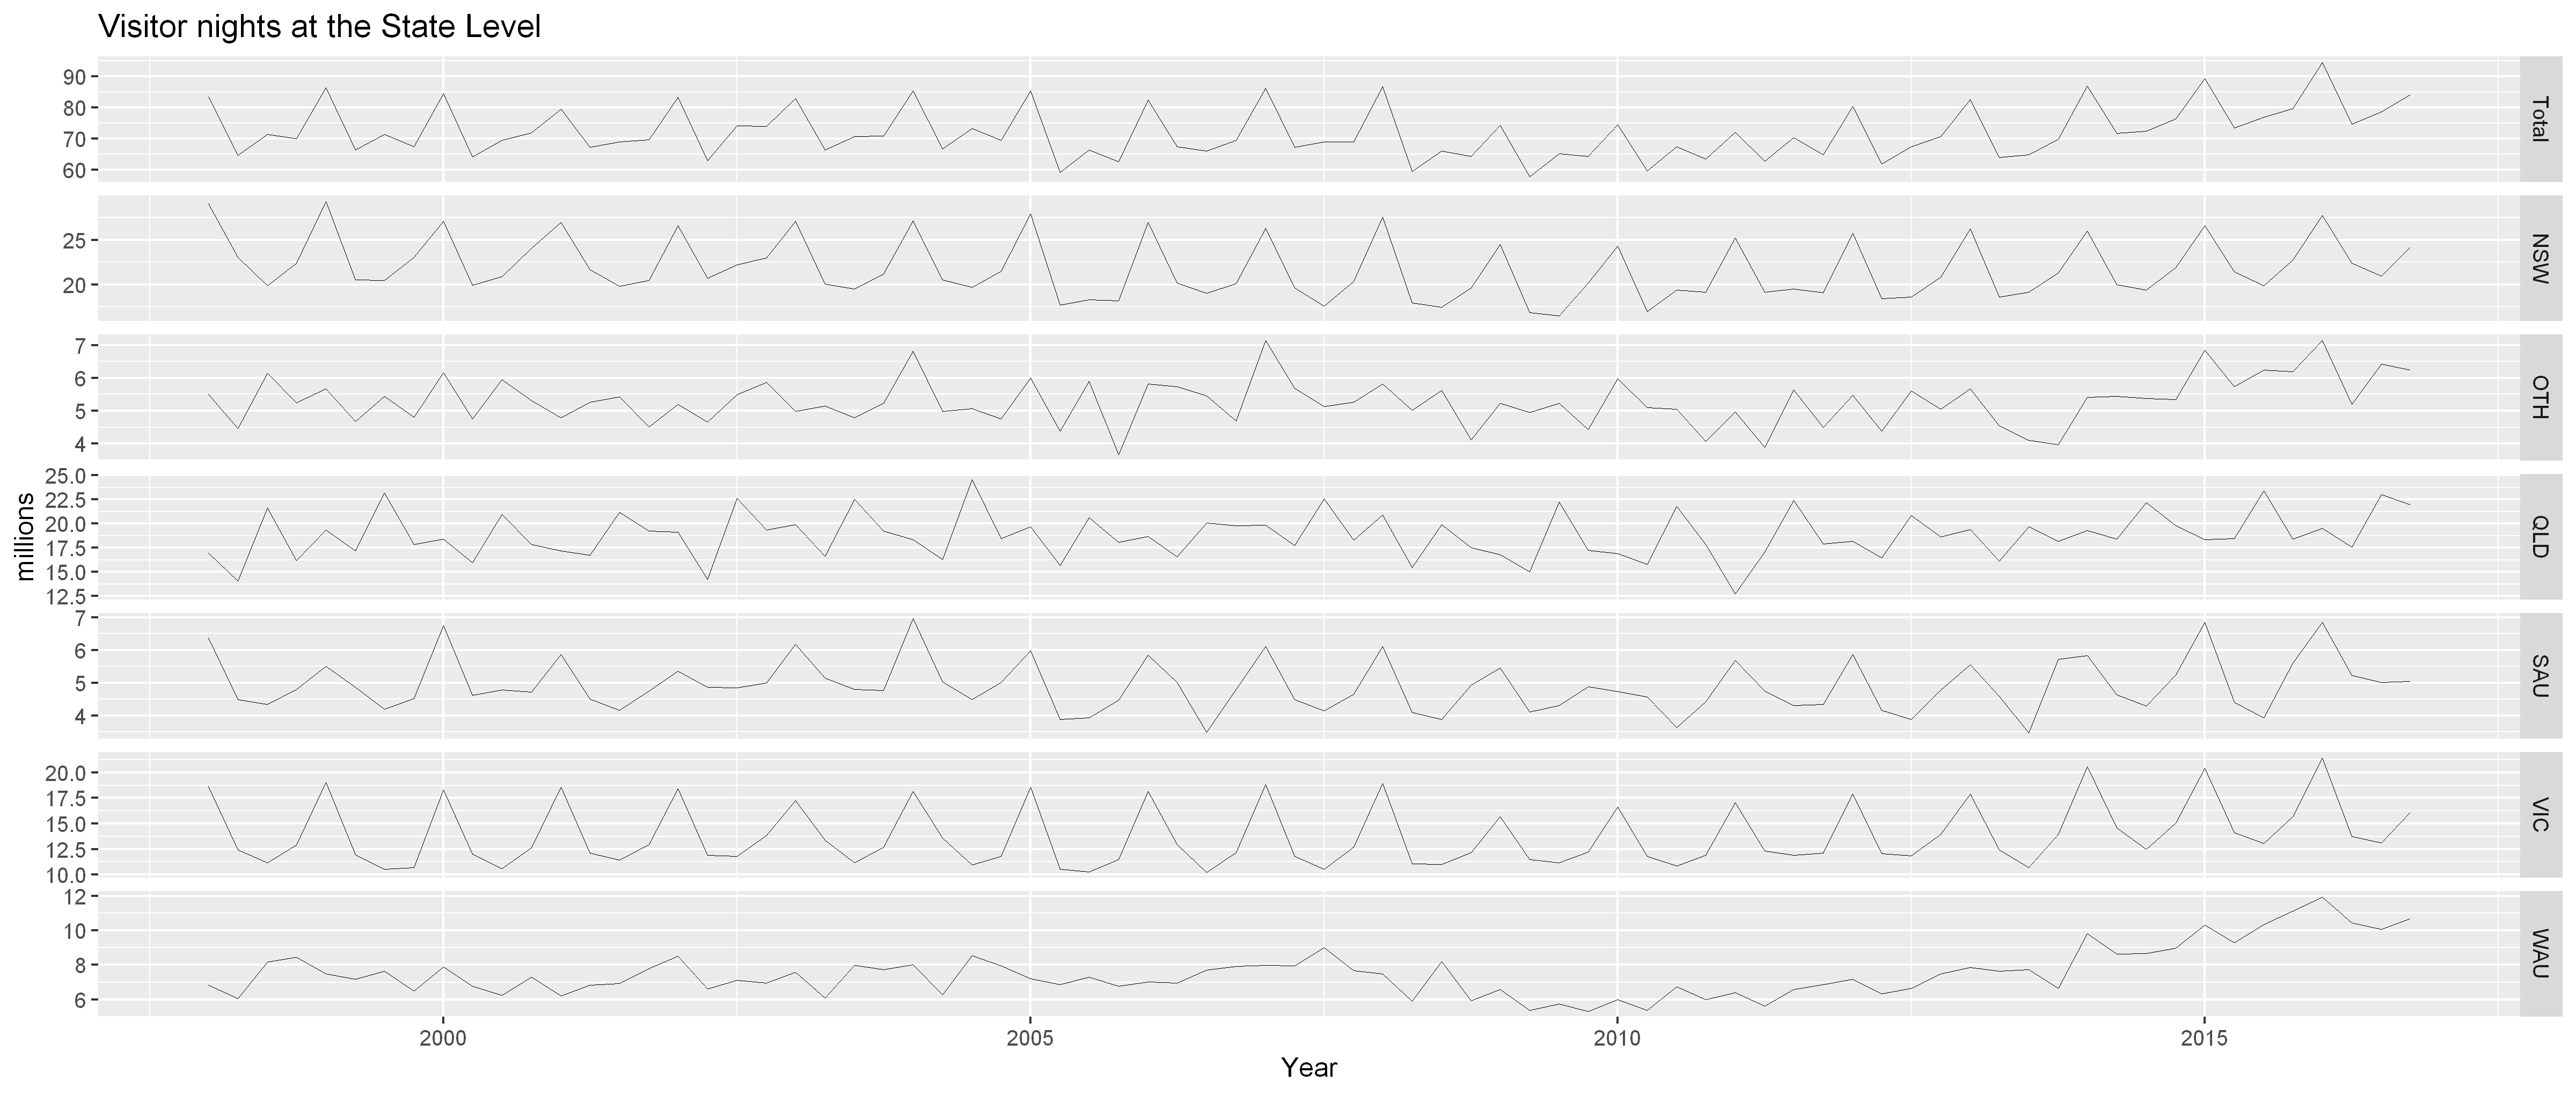

In [318]:
tourism.hts %>% aggts(levels=0:1) %>%
  autoplot(facet=TRUE) +
  xlab("Year") + ylab("millions") + ggtitle("Visitor nights at the State Level") + 
        theme_grey(base_size = 30)

It looks like NSW, QLD, and VIC have much larger magnitudes of visitors than other areas. States like NSW and VIC look to have a very predictible seasonality component while states like WAU and OTH have much less (if any) seasonality in their data.

### Plot the zone-level trends

In [319]:
#Resize the window in R
options(repr.plot.width = 15, repr.plot.height=30)

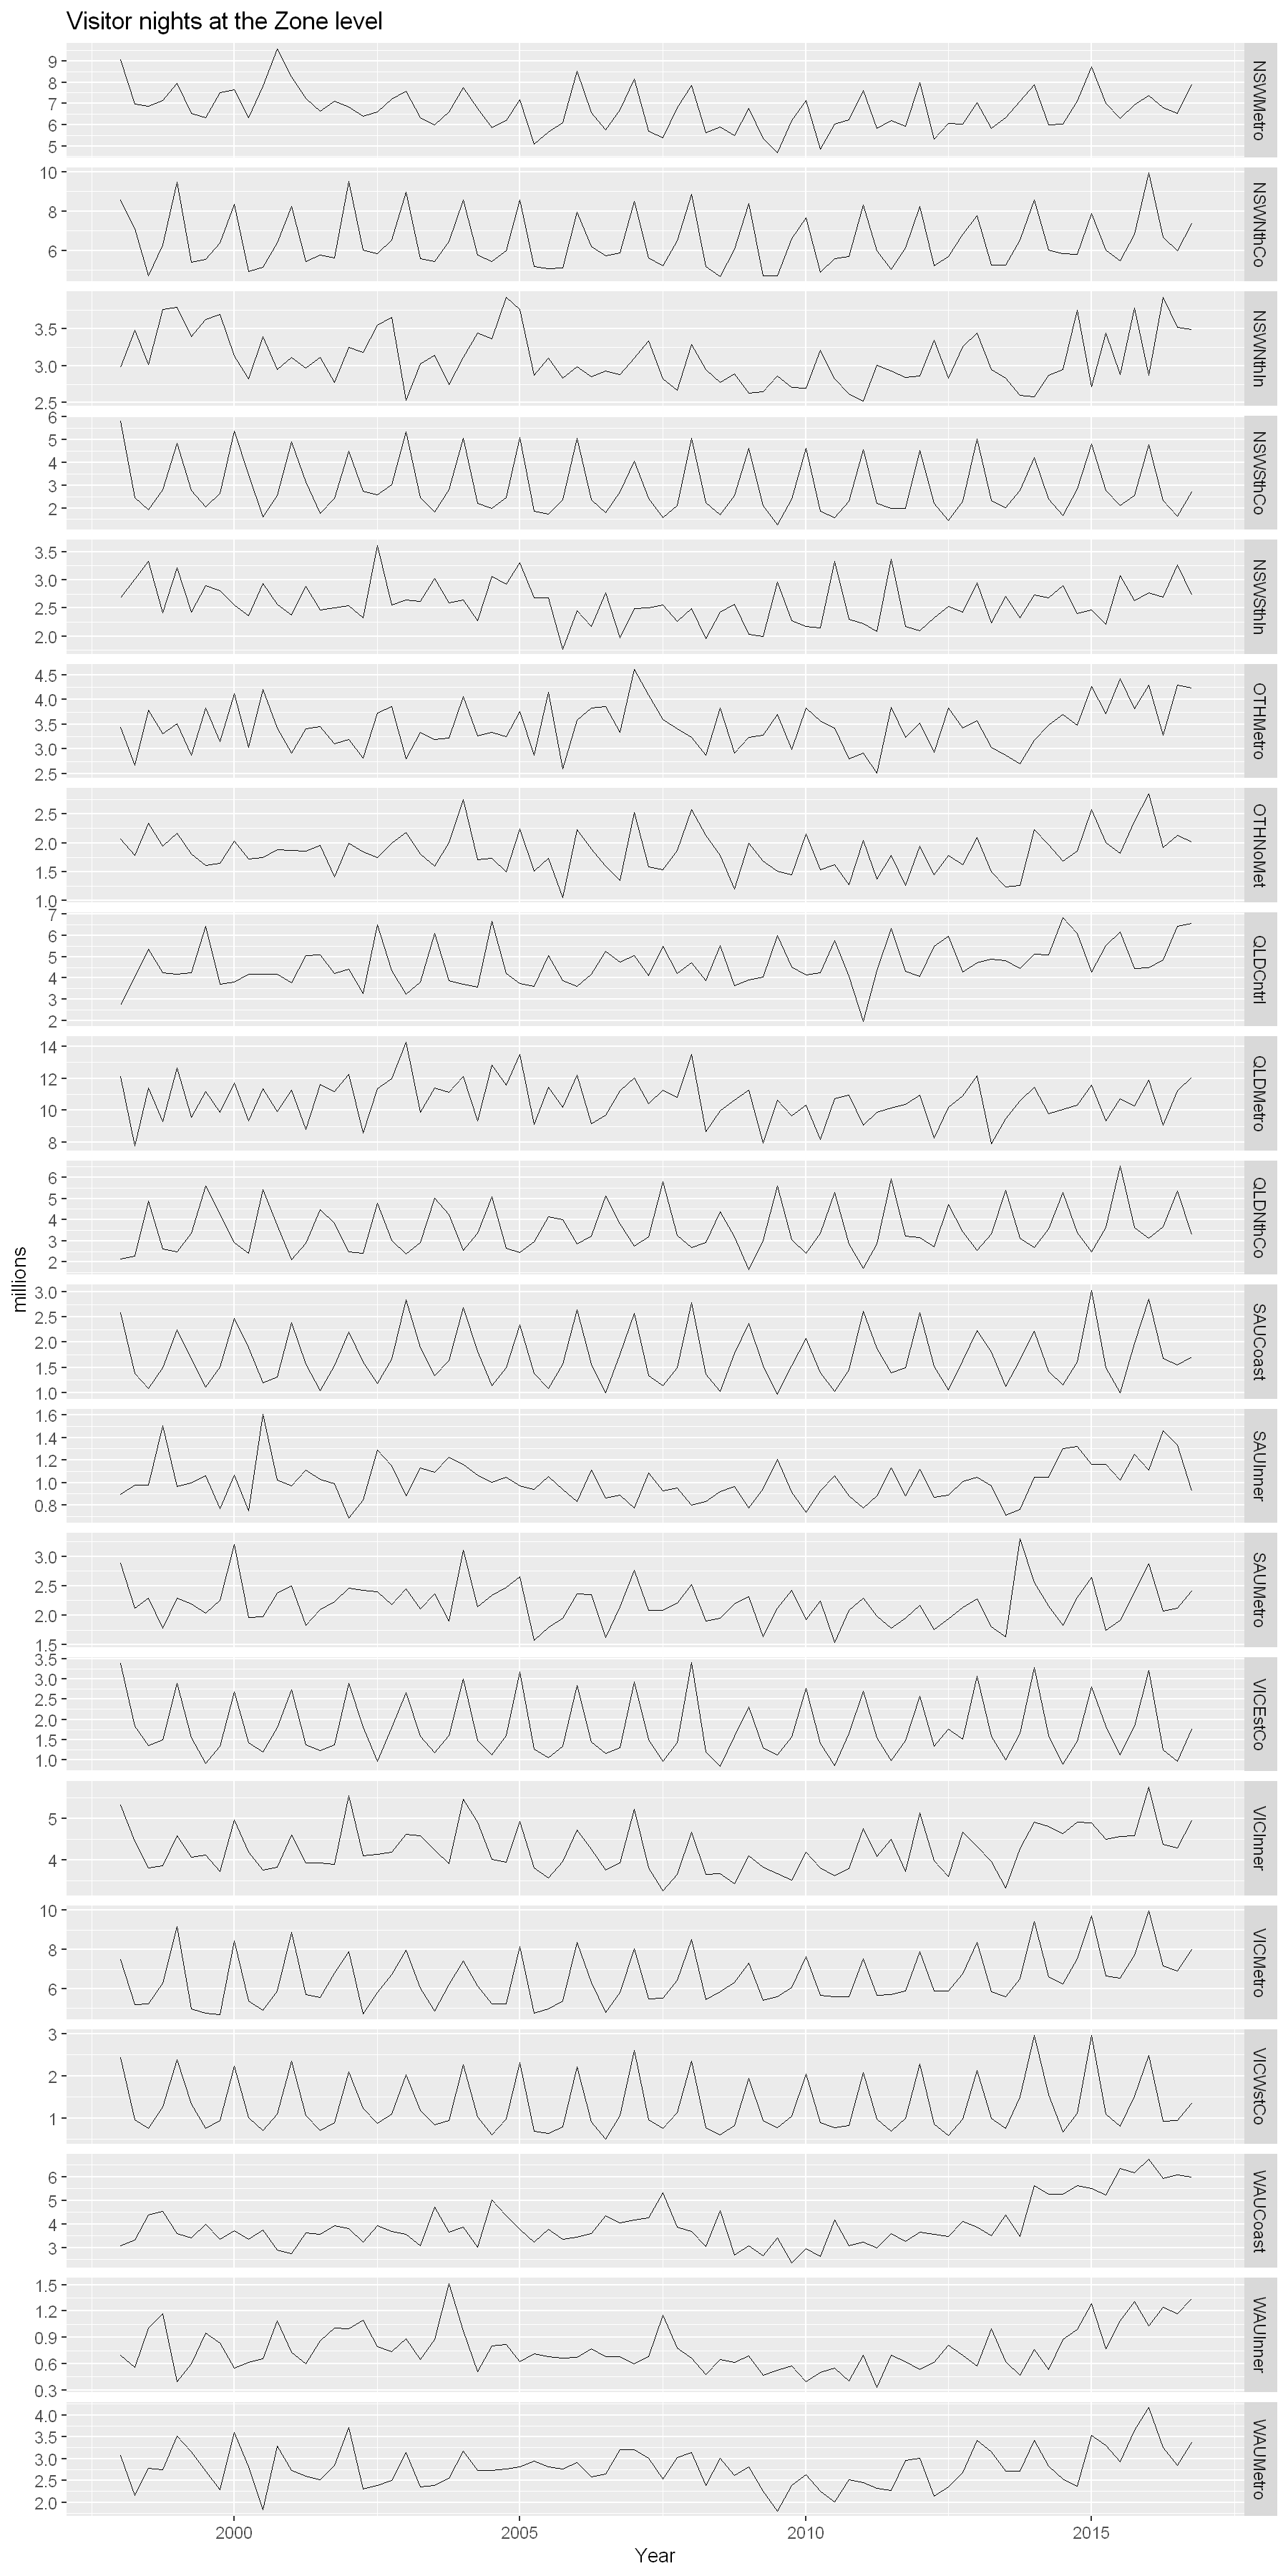

In [320]:
tourism.hts %>% aggts(levels=2) %>%
  autoplot(facet=TRUE) +
  xlab("Year") + ylab("millions") + ggtitle("Visitor nights at the Zone level") + 
        theme_grey(base_size = 17)

# Generate forecasts with HTS for 12 periods out (3 years)

Here is where we implement hierarchical modeling with a couple of different time series methodologies, [ETS](https://otexts.com/fpp3/expsmooth.html) and [ARIMA](https://otexts.com/fpp3/arima.html). We tell the forecast method that we want to use a combined (hierarchically reconcilied approach) as opposed to one like bottom-up by setting `method = 'comb'`. 

`fmethod` allows us to set the type of time series model we wish to use (ETS or ARIMA for instance). Here we set `fmethod = 'ets'`.

We can calculate the weights in our HTS model by using the Minimum Trace (MinT) methodology by setting `weights = 'mint'`. Using MinT guarantees that the forecasts produced by the HTS model *will be at least as good as the base forecasts* ([Wickramasuriya, Athanasopoulos, Hyndman, 2017](https://robjhyndman.com/papers/mint.pdf)).


### Using an ETS model

In [327]:
tourism.fc.ets <- forecast(tourism.hts, method = 'comb', fmethod = 'ets', weights = 'mint', h = 12)

In [328]:
tourism.fcsts.ets <- aggts(tourism.fc.ets, levels = 0:2)

In [329]:
#print out our forecasts
tourism.fcsts.ets

,Total,NSW,OTH,QLD,SAU,VIC,WAU,NSWMetro,NSWNthCo,NSWNthIn,NSWSthCo,NSWSthIn,OTHMetro,OTHNoMet,QLDCntrl,QLDMetro,QLDNthCo,SAUCoast,SAUInner,SAUMetro,VICEstCo,VICInner,VICMetro,VICWstCo,WAUCoast,WAUInner,WAUMetro
2017 Q1,95.27921,28.80263,6.951294,20.24484,6.516740,21.43484,11.32886,8.289042,9.375742,3.483692,4.849248,2.804907,4.259022,2.692271,4.840875,12.566362,2.837603,2.700668,1.263392,2.552681,2.982972,5.701801,9.996306,2.7537582,6.202930,1.188607,3.937328
2017 Q2,75.24274,21.63145,5.944050,17.82322,5.064147,14.71534,10.06453,6.709035,6.380761,3.455752,2.502710,2.583192,3.812086,2.131964,5.135517,9.403251,3.284455,1.780226,1.288312,1.995608,1.493699,4.800902,7.208756,1.2119853,5.774454,1.058951,3.231127
2017 Q3,80.12702,21.35941,6.486523,23.28390,4.661350,13.44174,10.89409,6.765555,6.105218,3.457689,1.865269,3.165683,4.349409,2.137114,6.613962,11.299542,5.370394,1.324700,1.315503,2.021146,1.116259,4.490164,6.988220,0.8471017,6.581177,1.243093,3.069817
2017 Q4,80.28410,23.10704,5.883253,19.98911,5.357562,15.22039,10.72674,7.426945,6.998114,3.457753,2.570619,2.653610,3.860224,2.023029,5.213823,11.121497,3.653784,1.774278,1.340574,2.242710,1.594352,4.628644,7.726986,1.2704103,6.022248,1.302720,3.401774
2018 Q1,95.41862,28.82629,6.952738,20.25676,6.581676,21.46206,11.33909,8.298956,9.384702,3.479259,4.857438,2.805934,4.259302,2.693435,4.850077,12.565218,2.841469,2.694181,1.354239,2.533256,2.984002,5.710386,10.007001,2.7606697,6.209434,1.190341,3.939315
2018 Q2,75.38215,21.65511,5.945493,17.83515,5.129083,14.74256,10.07476,6.718948,6.389721,3.451320,2.510900,2.584219,3.812366,2.133128,5.144719,9.402107,3.288321,1.773740,1.379160,1.976184,1.494729,4.809487,7.219451,1.2188959,5.780958,1.060685,3.233114
2018 Q3,80.26642,21.38307,6.487967,23.29582,4.726286,13.46896,10.90431,6.775468,6.114178,3.453256,1.873459,3.166710,4.349688,2.138278,6.623164,11.298398,5.374260,1.318214,1.406351,2.001722,1.117289,4.498749,6.998915,0.8540121,6.587681,1.244828,3.071804
2018 Q4,80.42350,23.13070,5.884697,20.00103,5.422498,15.24761,10.73697,7.436858,7.007074,3.453320,2.578809,2.654637,3.860504,2.024193,5.223025,11.120354,3.657650,1.767792,1.431421,2.223285,1.595382,4.637229,7.737682,1.2773210,6.028752,1.304454,3.403761
2019 Q1,95.55802,28.84995,6.954181,20.26869,6.646613,21.48928,11.34931,8.308869,9.393662,3.474827,4.865628,2.806961,4.259582,2.694599,4.859279,12.564075,2.845334,2.687694,1.445086,2.513832,2.985032,5.718972,10.017696,2.7675813,6.215938,1.192075,3.941301
2019 Q2,75.52156,21.67877,5.946937,17.84707,5.194020,14.76978,10.08498,6.728862,6.398681,3.446887,2.519090,2.585246,3.812645,2.134292,5.153921,9.400963,3.292186,1.767253,1.470007,1.956759,1.495758,4.818072,7.230146,1.2258065,5.787462,1.062419,3.235100


### Using an ARIMA model

Now we'll repeat the above process, but use ARIMA instead of ETS in the `fmethod` argument.

In [330]:
tourism.fc.arima <- forecast(tourism.hts, method = 'comb', fmethod = 'arima', weights = 'mint', h = 12)

In [331]:
tourism.fcsts.arima <- aggts(tourism.fc.arima, levels = 0:2)

In [332]:
#print out our forecasts
tourism.fcsts.arima

,Total,NSW,OTH,QLD,SAU,VIC,WAU,NSWMetro,NSWNthCo,NSWNthIn,NSWSthCo,NSWSthIn,OTHMetro,OTHNoMet,QLDCntrl,QLDMetro,QLDNthCo,SAUCoast,SAUInner,SAUMetro,VICEstCo,VICInner,VICMetro,VICWstCo,WAUCoast,WAUInner,WAUMetro
2017 Q1,93.14157,28.39694,6.463108,19.61945,6.325085,20.81162,11.52537,8.448757,9.031006,3.421854,4.746236,2.749084,3.913724,2.549384,4.555714,12.372072,2.691663,2.627119,1.072011,2.625955,3.1005887,5.332680,9.832408,2.5459413,6.529511,1.235917,3.759942
2017 Q2,75.50057,21.75232,5.529322,18.11628,4.932003,14.34467,10.82598,6.991067,6.105309,3.422041,2.520346,2.713557,3.635537,1.893784,5.102671,9.518643,3.494962,1.634828,1.109582,2.187592,1.5409352,4.637828,7.079040,1.0868694,6.210932,1.239861,3.375186
2017 Q3,79.63359,21.14800,5.936448,23.51322,4.664964,13.32624,11.04472,6.636036,5.992124,3.400338,1.950454,3.169046,3.945654,1.990794,6.298168,11.402294,5.812755,1.389483,1.103972,2.171510,0.9711701,4.482680,7.017517,0.8548736,6.658941,1.240874,3.144901
2017 Q4,81.21399,23.38898,5.669196,20.34830,5.261095,15.38458,11.16184,7.587459,6.926495,3.344720,2.754683,2.775619,3.877189,1.792007,5.329665,11.530742,3.487890,1.765403,1.100532,2.395161,1.6150114,4.617836,7.848099,1.3036372,6.472985,1.204696,3.484160
2018 Q1,93.74379,28.49905,6.248223,19.90238,6.482266,20.77128,11.84059,8.375871,9.083253,3.363897,4.841347,2.834680,3.845826,2.402397,4.586577,12.426608,2.889193,2.885963,1.100531,2.495772,2.9540350,5.323814,9.917299,2.5761327,6.873966,1.228686,3.737937
2018 Q2,76.67159,22.11853,5.571200,18.25936,4.997539,14.56604,11.15892,7.132272,6.285294,3.350799,2.573763,2.776402,3.703490,1.867710,5.117758,9.534969,3.606633,1.634311,1.122319,2.240909,1.5878796,4.632010,7.237536,1.1086132,6.567670,1.209853,3.381394
2018 Q3,80.17990,21.39606,5.827683,23.54064,4.635704,13.34338,11.43643,6.734682,6.087650,3.394860,1.986000,3.192869,3.920268,1.907415,6.346280,11.453346,5.741018,1.280437,1.132587,2.222679,1.0112508,4.419922,7.064827,0.8473851,6.981913,1.229128,3.225387
2018 Q4,81.82473,23.71404,5.594404,20.29118,5.318652,15.44325,11.46320,7.722995,7.053519,3.350825,2.779310,2.807392,3.831042,1.763362,5.402512,11.403706,3.484962,1.897043,1.107350,2.314259,1.6946212,4.565604,7.887940,1.2950840,6.815040,1.192587,3.455572
2019 Q1,94.51276,28.76121,6.278061,20.03523,6.462313,20.89194,12.08400,8.341890,9.227041,3.397483,4.889270,2.905522,3.868441,2.409620,4.618901,12.567351,2.848982,2.906915,1.132608,2.422789,3.0550240,5.271111,9.988204,2.5776061,7.197389,1.227217,3.659393
2019 Q2,77.62524,22.44811,5.651420,18.36124,5.078900,14.58274,11.50283,7.185354,6.405684,3.388651,2.625723,2.842694,3.762479,1.888941,5.158462,9.619123,3.583655,1.715557,1.134197,2.229146,1.4127616,4.628559,7.413509,1.1279123,6.897215,1.201265,3.404353


### Compare the two forecasts

In [333]:
#Define the groups in the HTS model
tourism.groups <- aggts(tourism.hts, levels = 0:2)

In [334]:
#Resize the window in R
options(repr.plot.width = 40, repr.plot.height=20)

For a multivariate timeseries, specify a seriesname for each timeseries. Defaulting to column names.

For a multivariate timeseries, specify a seriesname for each timeseries. Defaulting to column names.



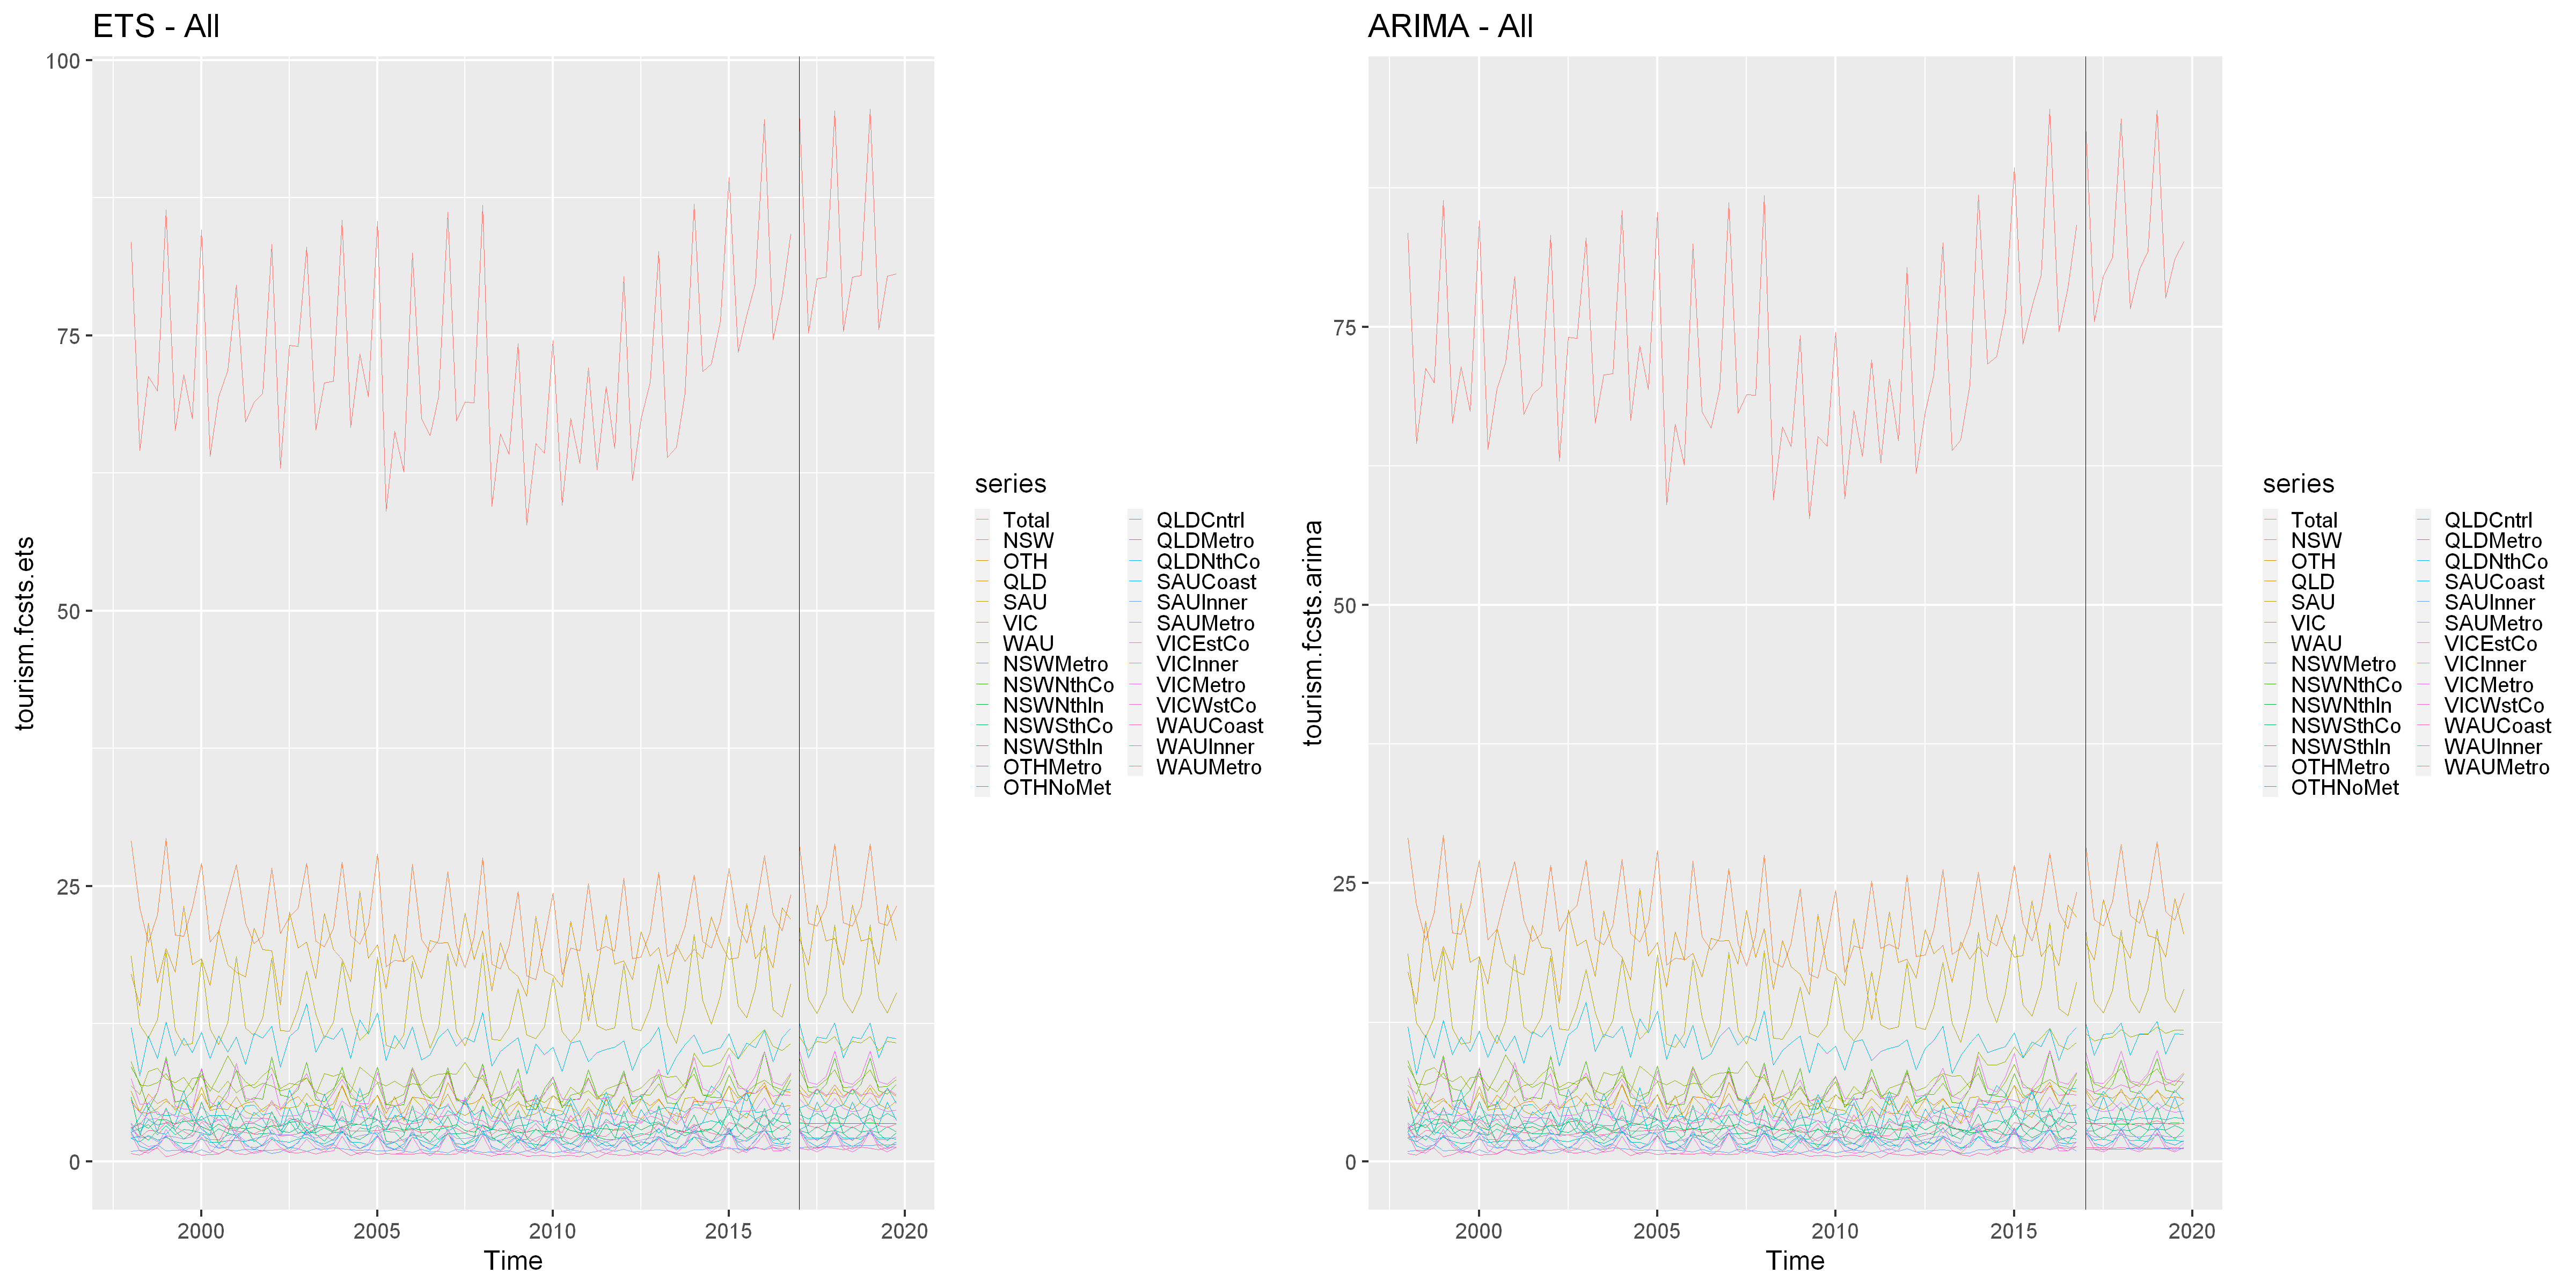

In [337]:
#Plot ETS and ARIMA
plot1 = autoplot(tourism.fcsts.ets) + autolayer(tourism.groups) + geom_vline(xintercept = 2017) + 
    ggtitle('ETS - All') + theme_grey(base_size = 30)

plot2 = autoplot(tourism.fcsts.arima) + autolayer(tourism.groups) + geom_vline(xintercept = 2017) + 
    ggtitle('ARIMA - All') + theme_grey(base_size = 30)

grid.arrange(plot1, plot2, ncol=2)

Above we can see that both approaches produce reasonable forecasts for each level of the time-series, ranging from the overall totals down to the most granular zone level. Let's take a look at the state- and zone-level forecasts separately.

### Highlight the state-level forecasts

For a multivariate timeseries, specify a seriesname for each timeseries. Defaulting to column names.

For a multivariate timeseries, specify a seriesname for each timeseries. Defaulting to column names.



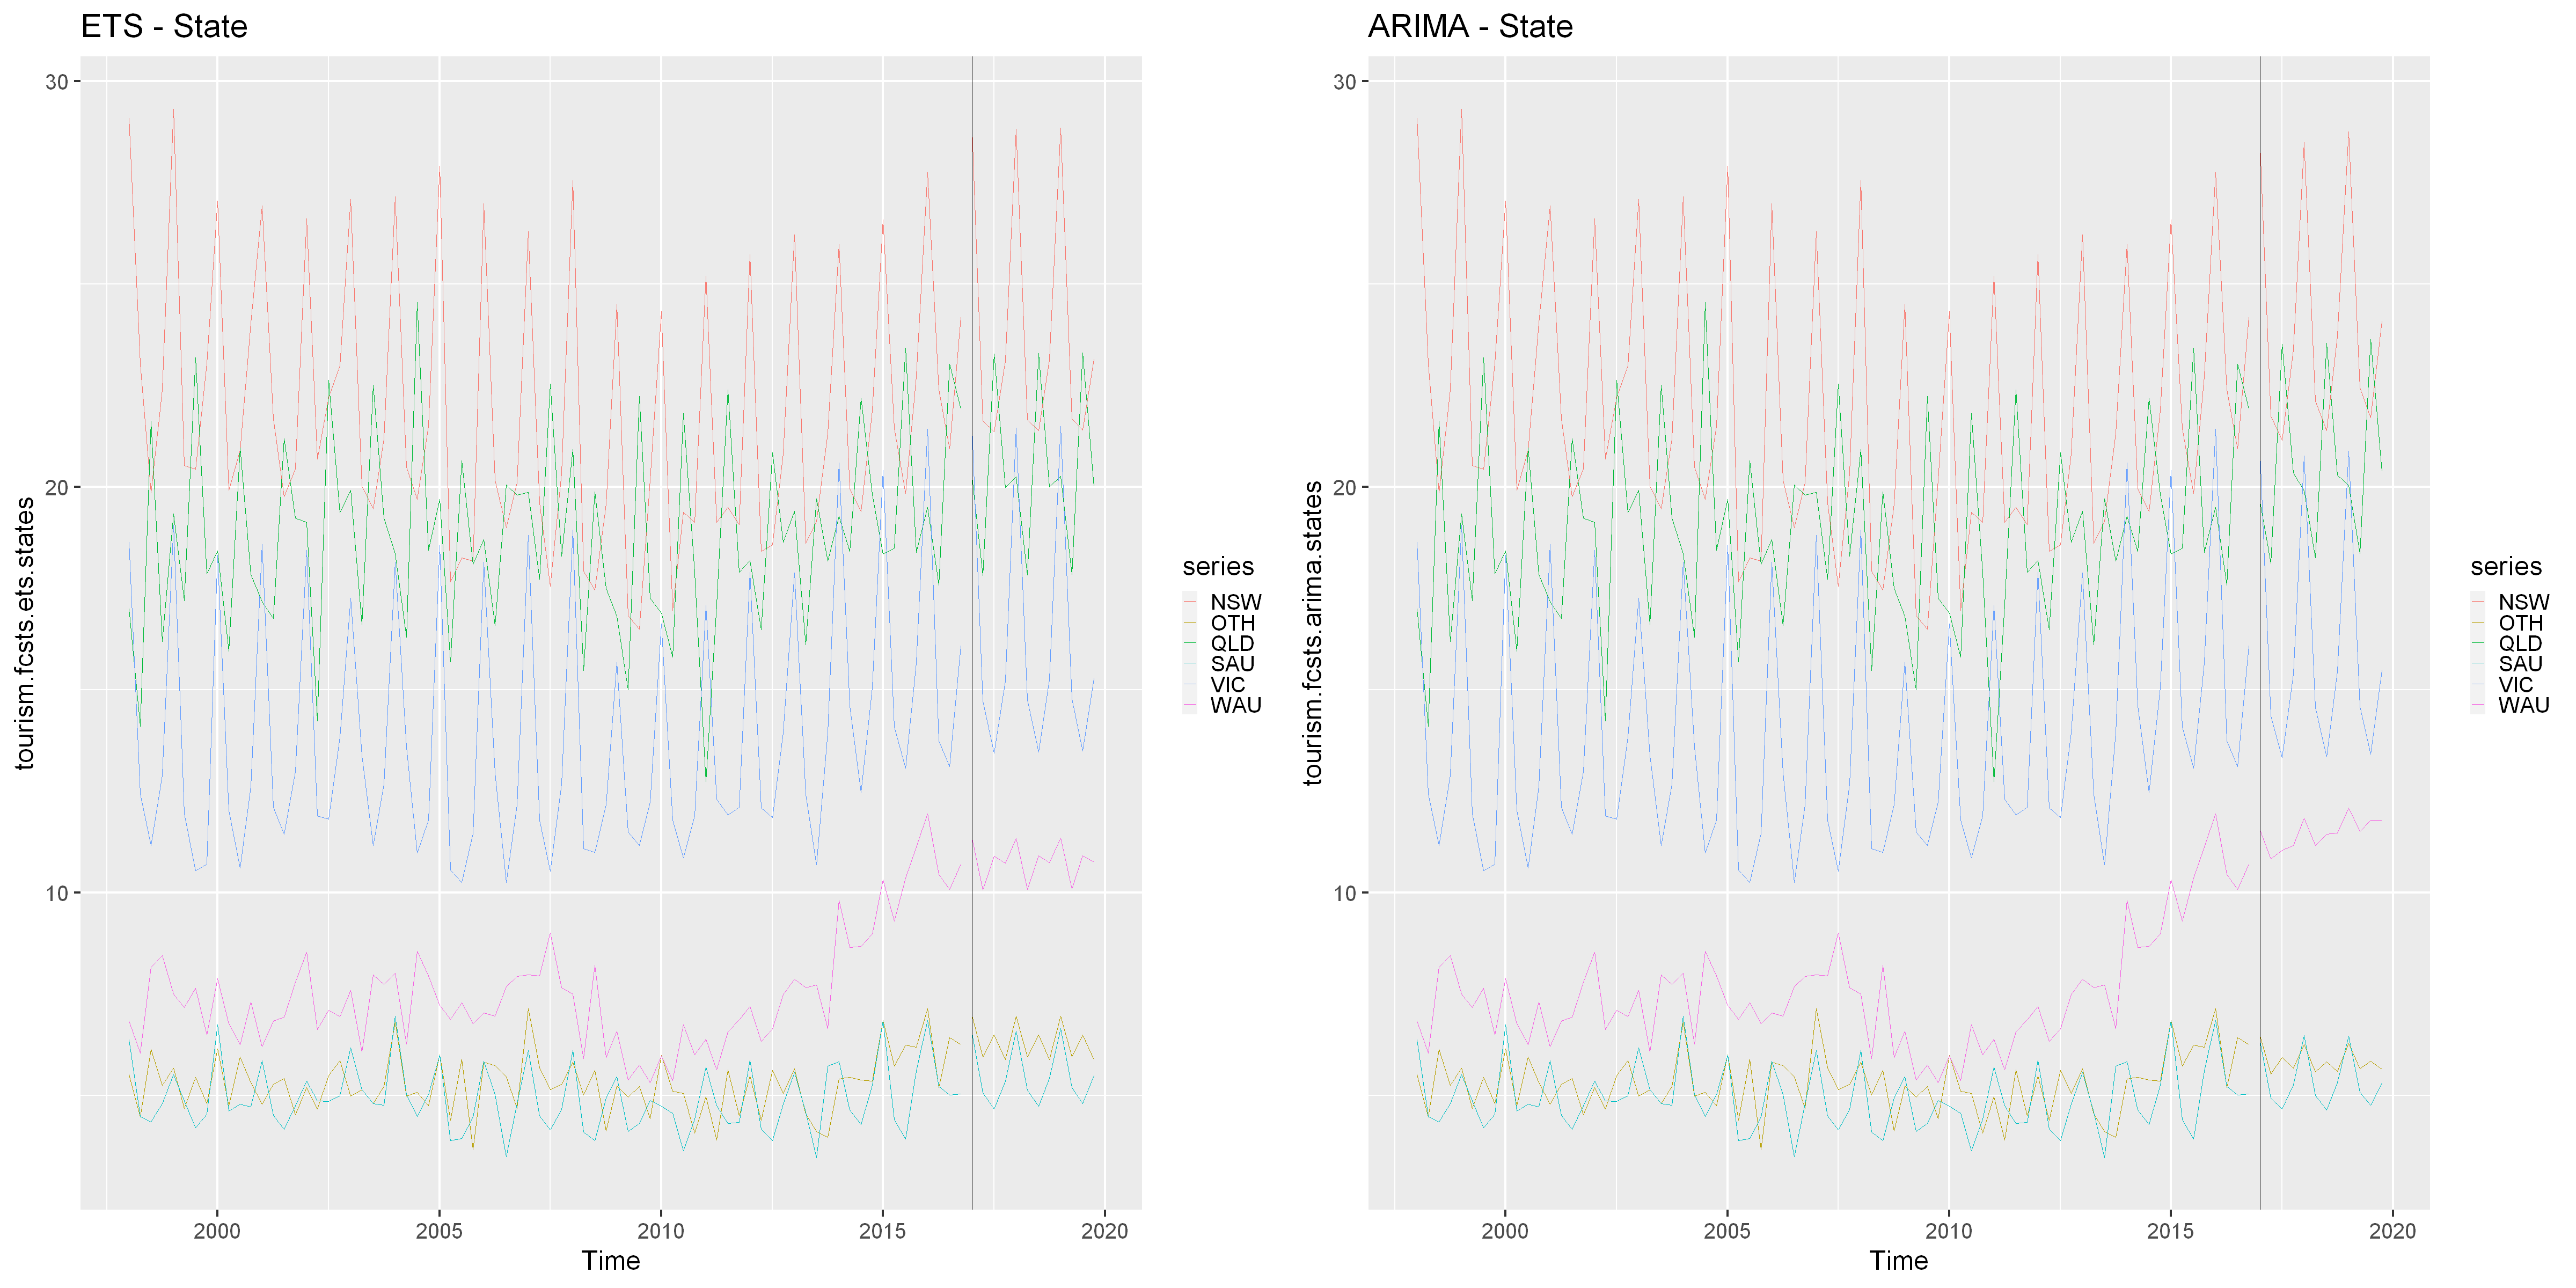

In [338]:
tourism.fcsts.ets.states <- aggts(tourism.fc.ets, levels = 1)
tourism.fcsts.arima.states <- aggts(tourism.fc.arima, levels = 1)

tourism.states <- aggts(tourism.hts, levels = 1)
#Plot ETS and ARIMA
plot3 = autoplot(tourism.fcsts.ets.states) + autolayer(tourism.states) + geom_vline(xintercept = 2017) +
    ggtitle('ETS - State') + theme_grey(base_size = 30)

plot4 = autoplot(tourism.fcsts.arima.states) + autolayer(tourism.states) + geom_vline(xintercept = 2017) +
    ggtitle('ARIMA - State') + theme_grey(base_size = 30)

grid.arrange(plot3, plot4, ncol=2)

### Highlight the Zone-level forecasts

For a multivariate timeseries, specify a seriesname for each timeseries. Defaulting to column names.

For a multivariate timeseries, specify a seriesname for each timeseries. Defaulting to column names.



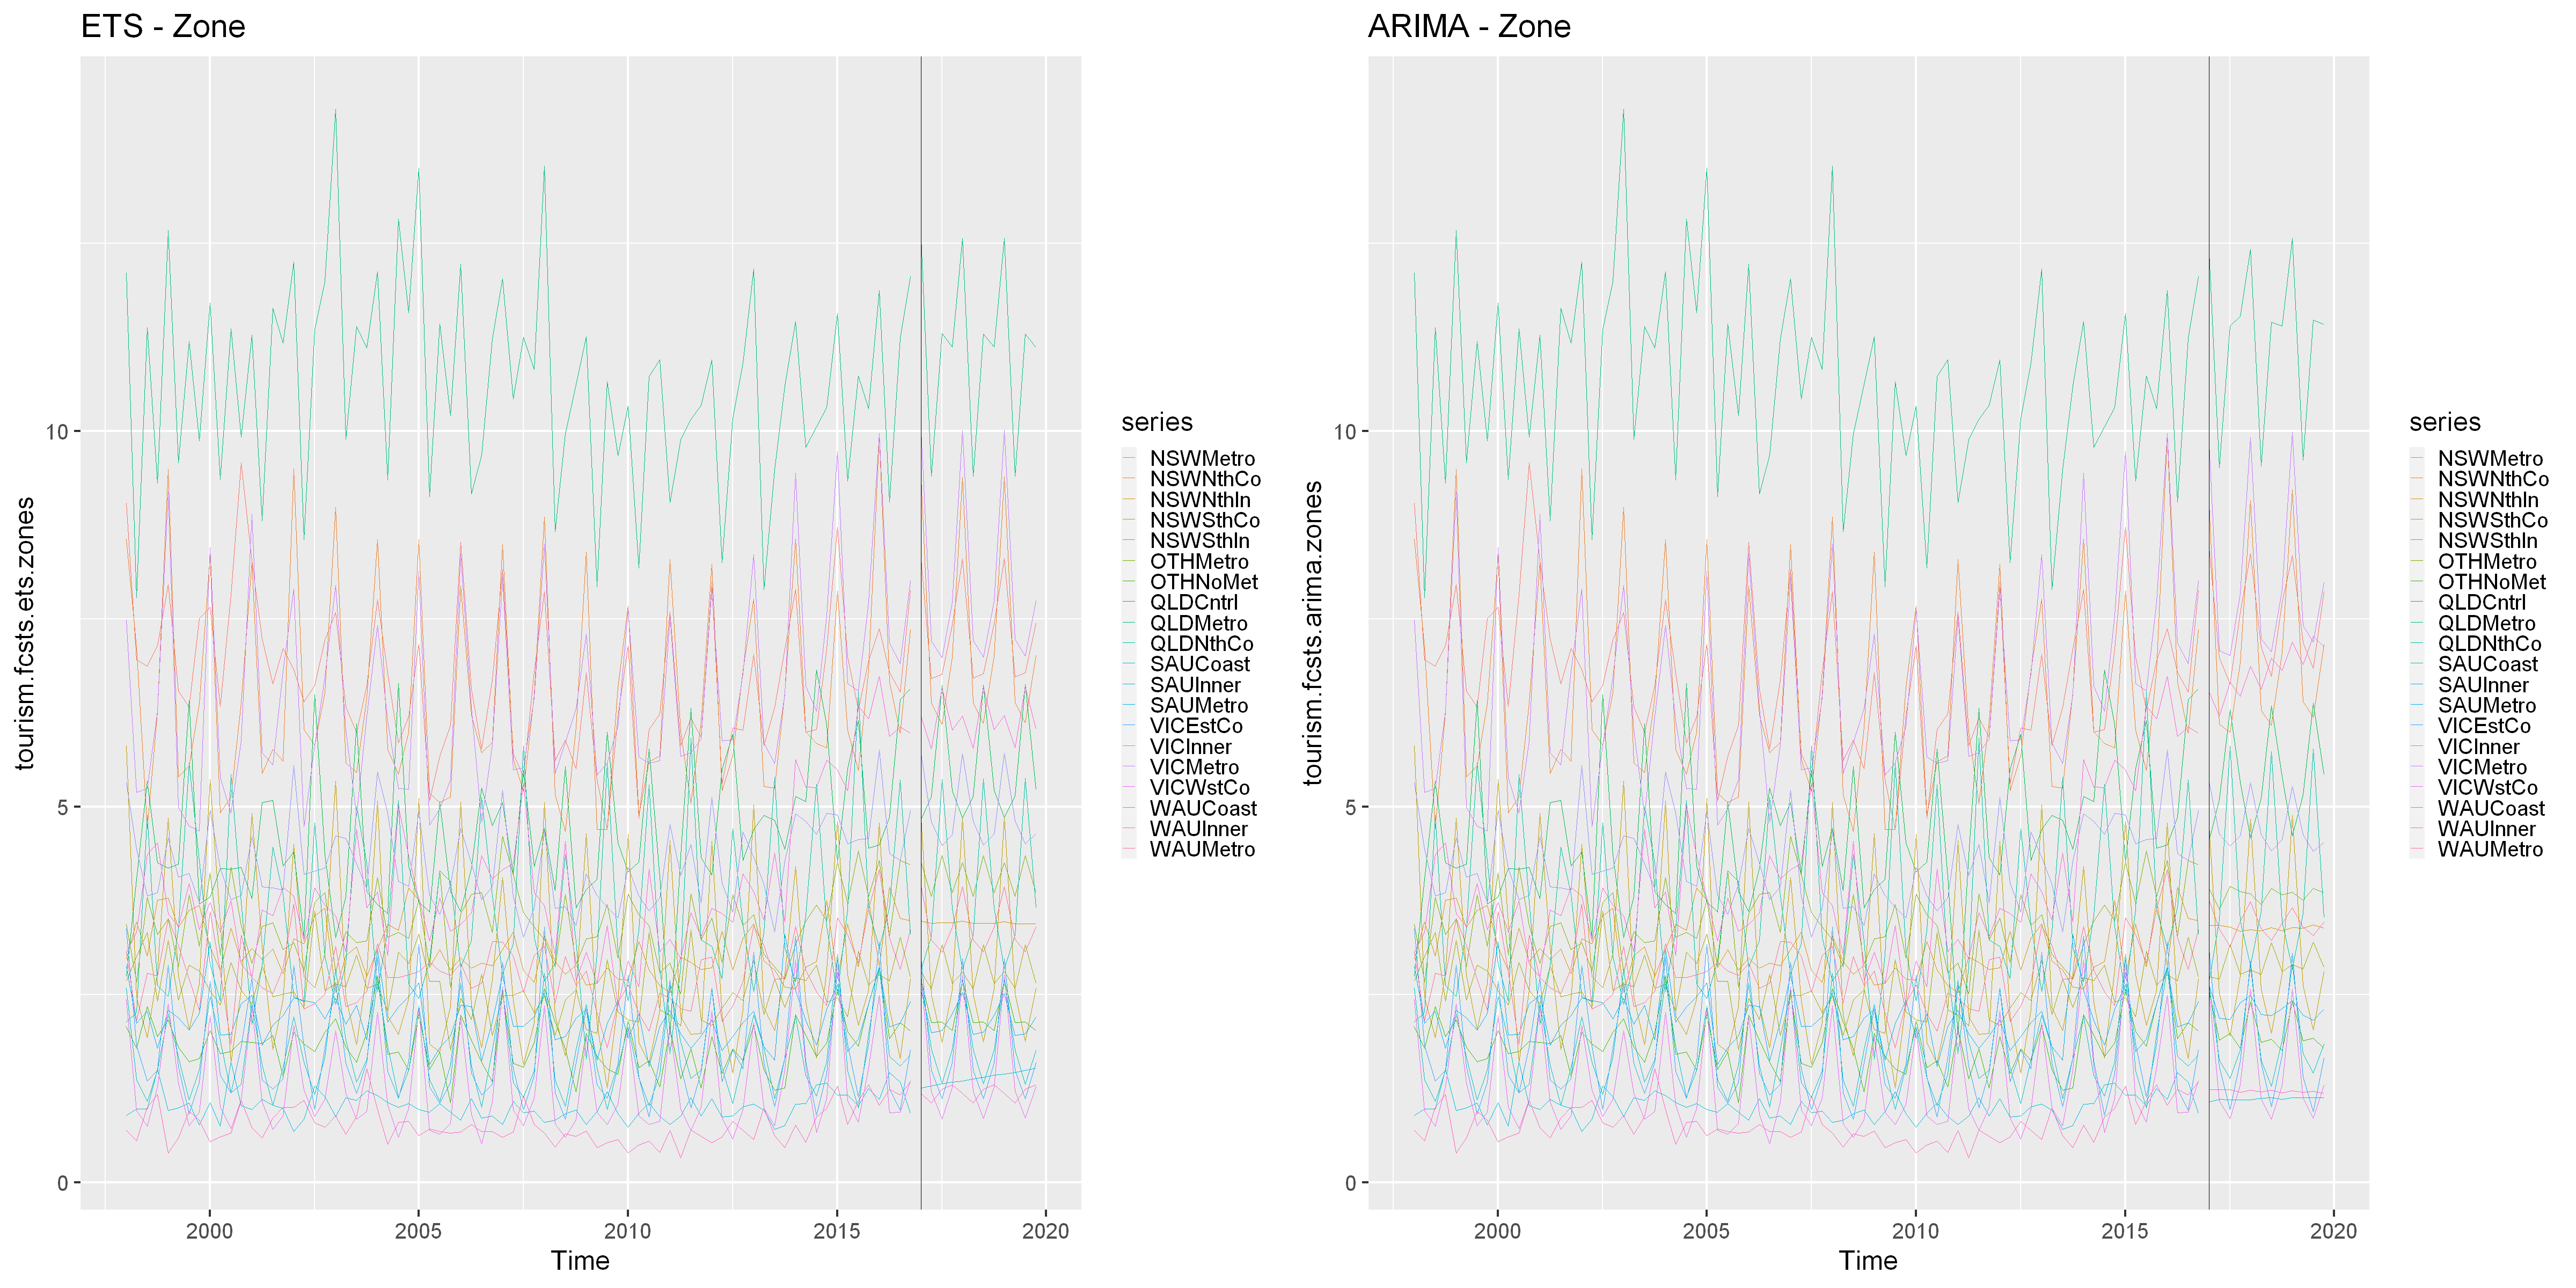

In [339]:
tourism.fcsts.ets.zones <- aggts(tourism.fc.ets, levels = 2)
tourism.fcsts.arima.zones <- aggts(tourism.fc.arima, levels = 2)

tourism.zones <- aggts(tourism.hts, levels = 2)
#Plot ETS and ARIMA
plot5 = autoplot(tourism.fcsts.ets.zones) + autolayer(tourism.zones) + geom_vline(xintercept = 2017) + 
    ggtitle('ETS - Zone') + theme_grey(base_size = 30)

plot6 = autoplot(tourism.fcsts.arima.zones) + autolayer(tourism.zones) + geom_vline(xintercept = 2017) + 
    ggtitle('ARIMA - Zone') + theme_grey(base_size = 30)

grid.arrange(plot5, plot6, ncol=2)

# Assess Accuracy of Each Method

### Time Series Cross-Validation

In time-series modeling, we would like a way for us to mimic the process of cross-validation that is typically used in cross-sectional data. However, traditional cross-validation is not available to us with time series modeling because we cannot randomly split our data to train our models - we cannot use future data points in our training set to predict observations in the past.

We are limited to just using past data in our training set when performing cross-validation. Thus, we can construct multiple training sets by starting with our earliest data in the time series and subsequent points as our validation set:

<img src = 'images/tsCV.jpg'>

<h4><center> R. Hyndman, "Forecasting: Principles and Practice", Section 5.10 </h4></center>

In the above diagram, we can think of every row as a training/validation split where blue dots represent our training set, red dots our validation set, and grey dots are excluded from that iteration. We start the process by declaring the minimum size of our training set, then repeat this process by increasing the size of our training set each time by a step size. In the above diagram, Hyndman starts with 6 observations in his training set and increases his training set by 1 in each iteration.

<img src = 'images/tsCV2.jpg'>

<h4><center> R. Hyndman, "Forecasting: Principles and Practice", Section 5.10 </h4></center>

We can also change how far out of a time horizon we want to forecast. In the first diagram, we were using the next observation (one period) after our training set as our validation set. In the above example, Hyndman uses the 4th oversation after the training set. If we are interested in a model that predicts 4 periods from our current time, we may opt for a time horizon of 4 instead of one when selecting our final model.

[Further reading on Time series cross-validation](https://otexts.com/fpp3/tscv.html)


We'll start by defining the common forms of models we are feeding into the HTS structure: ETS and ARIMA models

#### ARIMA TS Cross Validation

In [184]:
#This defines a generic model form for the ARIMA model
ARIMA.model.form <- function(x,h){forecast(Arima(x), h = h)}

In [190]:
#We'll do this for the first time series in our dataset, for NSWMetro
e.arima <- tsCV(visnights[,1], ARIMA.model.form, h = 12)
e.arima

,h=1,h=2,h=3,h=4,h=5,h=6,h=7,h=8,h=9,h=10,h=11,h=12
1998 Q1,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA
1998 Q2,-1.13264760,-0.85731803,-0.04768783,-1.462367380,-1.67424656,-0.49539845,-0.34212014,-1.66280876,-0.17730999,1.57495158,0.2658777,-0.76418401
1998 Q3,-0.47976883,0.32986137,-1.08481818,-1.296697366,-0.11784925,0.03542906,-1.28525956,0.20023920,1.95250078,0.64342694,-0.3866348,-0.98657180
1998 Q4,0.44980358,-0.96487597,-1.17675516,0.002092954,0.15537127,-1.16531735,0.32018141,2.07244299,0.76336915,-0.26669260,-0.8666296,-0.39524446
1999 Q1,-1.05483669,-1.26671587,-0.08786776,0.065410550,-1.25527807,0.23022070,1.98248227,0.67340844,-0.35665332,-0.95659031,-0.4852052,-0.76925424
1999 Q2,-1.09090976,0.08793835,0.24121667,-1.079471952,0.40602681,2.15828839,0.84921455,-0.18084720,-0.78078419,-0.30939906,-0.5934481,-1.01628180
1999 Q3,0.24378260,0.39706092,-0.92362770,0.561871063,2.31413264,1.00505880,-0.02500295,-0.62493994,-0.15355481,-0.43760388,-0.8604376,-0.64966945
1999 Q4,0.36658809,-0.95410053,0.53139824,2.283659814,0.97458598,-0.05547578,-0.65541277,-0.18402763,-0.46807670,-0.89091038,-0.6801423,-0.06952594
2000 Q1,-0.99483254,0.49066623,2.24292780,0.933853968,-0.09620779,-0.69614478,-0.22475964,-0.50880871,-0.93164239,-0.72087429,-0.1102579,0.25242383
2000 Q2,0.59014948,2.34241106,1.03333722,0.003275466,-0.59666152,-0.12527639,-0.40932546,-0.83215913,-0.62139103,-0.01077469,0.3519071,-0.90262398


#### ETS TS Cross Validation

In [189]:
ets.model.form <- function(x,h){forecast(ets(x), h = h)}

In [192]:
e.ets <- tsCV(visnights[,1], ets.model.form, h = 12)
e.ets

,h=1,h=2,h=3,h=4,h=5,h=6,h=7,h=8,h=9,h=10,h=11,h=12
1998 Q1,-2.08496951,-2.17513235,-1.89980279,-1.090172583,-2.50485213,-2.71673132,-1.53788321,-1.38460489,-2.70529351,-1.21979475,0.532466829,-0.77660701
1998 Q2,-2.07088387,-1.79555431,-0.98592411,-2.400603658,-2.61248284,-1.43363473,-1.28035642,-2.60104504,-1.11554627,0.63671530,-0.672358532,-1.70242029
1998 Q3,0.27532956,1.08495977,-0.32971978,-0.541598969,0.63724914,0.79052745,-0.53016116,0.95533760,2.70759918,1.39852534,0.368463586,-0.23147340
1998 Q4,0.80963020,-0.60504935,-0.81692853,0.361919578,0.51519789,-0.80549073,0.68000804,2.43226961,1.12319578,0.09313402,-0.506802966,-0.03541783
1999 Q1,-1.41467955,-1.62655874,-0.44771062,-0.294432312,-1.61512093,-0.12962217,1.62263941,0.31356557,-0.71649618,-1.31643317,-0.845048036,-1.12909710
1999 Q2,-0.50430835,0.67453976,0.82781807,-0.492870546,0.99262822,2.74488979,1.43581596,0.40575420,-0.19418279,0.27720235,-0.006846722,-0.42968040
1999 Q3,0.24379082,0.39706913,-0.92361949,0.561879274,2.31414085,1.00506701,-0.02499474,-0.62493173,-0.15354660,-0.43759566,-0.860429339,-0.64966124
1999 Q4,0.36657614,-0.95411247,0.53138629,2.283647868,0.97457403,-0.05548772,-0.65542471,-0.18403958,-0.46808865,-0.89092232,-0.680154224,-0.06953788
2000 Q1,-0.99494790,0.49055086,2.24281244,0.933738604,-0.09632315,-0.69626014,-0.22487501,-0.50892408,-0.93175775,-0.72098965,-0.110373311,0.25230847
2000 Q2,0.59003011,2.34229169,1.03321785,0.003156097,-0.59678089,-0.12539576,-0.40944483,-0.83227850,-0.62151040,-0.01089406,0.351787715,-0.90274335


In [191]:
sqrt(colMeans(e.arima^2, na.rm = TRUE))

h=1       h=2       h=3       h=4       h=5       h=6       h=7       h=8 
0.9843332 0.9958389 0.9936289 1.0147064 1.0344655 1.0214597 1.0202570 1.0392821 
      h=9      h=10      h=11      h=12 
1.0461384 1.0515885 1.0357085 1.0523185

In [194]:
sqrt(colMeans(e.ets^2, na.rm = TRUE))

h=1       h=2       h=3       h=4       h=5       h=6       h=7       h=8 
0.7602728 0.8138685 0.7686270 0.7590659 0.9102600 0.8908351 0.8070109 0.8437720 
      h=9      h=10      h=11      h=12 
0.9833756 0.9080283 0.8527612 0.8594376

Overall, based upon cross-validation forecast accuracy, it appears that the ETS model fares better in prediction accuracy at all time-horizons $h$ compared to the ARIMA model.

### Now try with HTS 

Not working since tsCV will only take a single TS object and not an HTS object

In [172]:
hts.model.form <- function(x, h){forecast(x, method = 'comb', fmethod = 'arima', weights = 'mint', h = h)}

In [178]:
tsCV(visnights, hts.model.form, h = 12)

ERROR: Error in attr(x, "tsp") <- value: invalid time series parameters specified


## Split into Train and Test to Assess Model Accuracy

Another way we can assess model performance is by simply splitting our time series data into training and validation sets. In our case, we will reserve the last 12 periods of our data (3 years) as our validation set, and use all prior data as our training data.

In [255]:
#Split our data, reserving the last 12 periods for validation
train.test.split <- ts_split(visnights, sample.out = 12)

In [256]:
#Define our train and test data
train.data <- train.test.split$train
test.data <- train.test.split$test

In [257]:
#Convert our datasets into HTS objects
tourism.hts.train <- hts(train.data, characters = c(3, 5))
tourism.hts.test <- hts(test.data, characters = c(3, 5))

In [233]:
#Build an HTS model with ARIMA, estimating our weights with MinT
tourism.fc.arima <- forecast(tourism.hts.train, method = 'comb', fmethod = 'arima', weights = 'mint', h = 12)

In [236]:
#Build an HTS model with ETS, estimating our weights with MinT
tourism.fc.ets <- forecast(tourism.hts.train, method = 'comb', fmethod = 'ets', weights = 'mint', h = 12)

In [270]:
#Compare the accuracy of these two models
acc.arima <- t(accuracy(tourism.fc.arima, tourism.hts.test))
acc.ets <- t(accuracy(tourism.fc.ets, tourism.hts.test))

colnames(acc.arima) <- paste(colnames(acc.arima), "arima", sep = "_")
colnames(acc.ets) <- paste(colnames(acc.ets), "ets", sep = "_")

acc.all <- cbind(acc.arima, acc.ets)
acc.all[, c(1, 7, 2, 8, 3, 9, 4 ,10, 5, 11, 6, 12)]

,ME_arima,ME_ets,RMSE_arima,RMSE_ets,MAE_arima,MAE_ets,MAPE_arima,MAPE_ets,MPE_arima,MPE_ets,MASE_arima,MASE_ets
Total,10.541972202,10.09545974,10.9801822,10.5969147,10.5419722,10.0954597,13.171443,12.623938,13.1714431,12.6239383,3.4567798,3.3103655
NSW,1.899172477,1.53643584,2.3267513,1.9265929,1.9787513,1.6003815,8.838824,7.123096,8.5325543,6.8769927,1.7473491,1.4132272
OTH,1.225108432,1.06509516,1.3530925,1.2016539,1.2251084,1.0717219,19.872770,17.406496,19.8727697,17.2840474,2.0266687,1.7729249
QLD,1.712484568,1.72122758,1.9485223,1.9776907,1.7124846,1.7212276,8.377621,8.570477,8.3776211,8.5704766,1.2672027,1.2736723
SAU,0.447664822,0.50204402,0.6284034,0.6644132,0.4830562,0.5320891,8.574512,9.549336,7.7304603,8.8236508,1.0697340,1.1783181
VIC,2.291761076,2.41996232,2.3857675,2.5045815,2.2917611,2.4199623,14.335971,15.283749,14.3359714,15.2837488,3.3355252,3.5221147
WAU,2.965780828,2.85069482,3.1305130,2.9991050,2.9657808,2.8506948,28.898173,27.849339,28.8981732,27.8493395,3.7756871,3.6291729
NSWMetro,0.794761817,0.46732756,0.9726049,0.6530055,0.7947618,0.5147273,11.077087,6.998065,11.0770873,6.3402679,1.2366721,0.8009303
NSWNthCo,0.624999583,0.52356563,0.8686589,0.7916929,0.7543060,0.6858363,10.876273,9.878677,8.9861295,7.5488198,1.4031008,1.2757389
NSWNthIn,0.270545708,0.30471378,0.5118554,0.5406243,0.4093947,0.4229607,11.762942,12.083470,6.6662544,7.6763709,1.1429061,1.1807782


When trying to predict future visitors to different states and zones of Australia, it our ETS model outperforms the ARIMA model with an HTS framework.

# Not working code

Failed attempts at implementing time series cross validation on hierarchical time series objects

In [113]:
NSWMetro = visnights[,1]
NSWMetro

,Qtr1,Qtr2,Qtr3,Qtr4
1998,9.047095,6.962126,6.871963,7.147293
1999,7.956923,6.542243,6.330364,7.509212
2000,7.662491,6.341802,7.827301,9.579562
2001,8.270488,7.240427,6.640490,7.111875
2002,6.827826,6.404992,6.615760,7.226376
2003,7.589058,6.334527,5.996748,6.612846
2004,7.758267,6.778836,5.854452,6.200214
2005,7.163830,5.082204,5.673551,6.089906
2006,8.525916,6.569684,5.771059,6.692897
2007,8.158658,5.710082,5.402543,6.803494


In [119]:
NSWMetro_tsib <- as_tsibble(NSWMetro)

head(NSWMetro_tsib, 10)

tail(NSWMetro_tsib, 10)

index,value
<qtr>,<dbl>
1998 Q1,9.047095
1998 Q2,6.962126
1998 Q3,6.871963
1998 Q4,7.147293
1999 Q1,7.956923
1999 Q2,6.542243
1999 Q3,6.330364
1999 Q4,7.509212
2000 Q1,7.662491


index,value
<qtr>,<dbl>
2014 Q3,6.033533
2014 Q4,7.103398
2015 Q1,8.725132
2015 Q2,6.995875
2015 Q3,6.294490
2015 Q4,6.945476
2016 Q1,7.373757
2016 Q2,6.792234
2016 Q3,6.530568


In [116]:
NSWMetro.ts.xval <- NSWMetro_tsib %>%
    stretch_tsibble(.init = 3, .step = 1)

head(NSWMetro.ts.xval, 10)

tail(NSWMetro.ts.xval, 10)

index,value,.id
<qtr>,<dbl>,<int>
1998 Q1,9.047095,1
1998 Q2,6.962126,1
1998 Q3,6.871963,1
1998 Q1,9.047095,2
1998 Q2,6.962126,2
1998 Q3,6.871963,2
1998 Q4,7.147293,2
1998 Q1,9.047095,3
1998 Q2,6.962126,3


index,value,.id
<qtr>,<dbl>,<int>
2014 Q3,6.033533,74
2014 Q4,7.103398,74
2015 Q1,8.725132,74
2015 Q2,6.995875,74
2015 Q3,6.294490,74
2015 Q4,6.945476,74
2016 Q1,7.373757,74
2016 Q2,6.792234,74
2016 Q3,6.530568,74


In [125]:
for(i in 1:20){
    ets(visnights[,1])
}

In [96]:
visnights_tsibble <- as_tsibble(visnights)

head(visnights_tsibble, 10)

tail(visnights_tsibble, 10)

index,key,value
<qtr>,<chr>,<dbl>
1998 Q1,NSWMetro,9.047095
1998 Q2,NSWMetro,6.962126
1998 Q3,NSWMetro,6.871963
1998 Q4,NSWMetro,7.147293
1999 Q1,NSWMetro,7.956923
1999 Q2,NSWMetro,6.542243
1999 Q3,NSWMetro,6.330364
1999 Q4,NSWMetro,7.509212
2000 Q1,NSWMetro,7.662491


index,key,value
<qtr>,<chr>,<dbl>
2014 Q3,OTHNoMet,1.683020
2014 Q4,OTHNoMet,1.858237
2015 Q1,OTHNoMet,2.574935
2015 Q2,OTHNoMet,2.010583
2015 Q3,OTHNoMet,1.819066
2015 Q4,OTHNoMet,2.379368
2016 Q1,OTHNoMet,2.853101
2016 Q2,OTHNoMet,1.917090
2016 Q3,OTHNoMet,2.131902


In [97]:
visnights.ts.xval <- visnights_tsibble %>%
    stretch_tsibble(.init = 3, .step = 1)

head(visnights.ts.xval, 10)

tail(visnights.ts.xval, 10)

index,key,value,.id
<qtr>,<chr>,<dbl>,<int>
1998 Q1,NSWMetro,9.047095,1
1998 Q2,NSWMetro,6.962126,1
1998 Q3,NSWMetro,6.871963,1
1998 Q1,NSWNthCo,8.565678,1
1998 Q2,NSWNthCo,7.124468,1
1998 Q3,NSWNthCo,4.716893,1
1998 Q1,NSWNthIn,2.977507,1
1998 Q2,NSWNthIn,3.477703,1
1998 Q3,NSWNthIn,3.014770,1


index,key,value,.id
<qtr>,<chr>,<dbl>,<int>
2014 Q3,WAUMetro,2.538617,74
2014 Q4,WAUMetro,2.363583,74
2015 Q1,WAUMetro,3.527544,74
2015 Q2,WAUMetro,3.304529,74
2015 Q3,WAUMetro,2.922297,74
2015 Q4,WAUMetro,3.640983,74
2016 Q1,WAUMetro,4.169990,74
2016 Q2,WAUMetro,3.262924,74
2016 Q3,WAUMetro,2.837998,74


In [ ]:
forecast(tourism.hts, method = 'comb', fmethod = 'ets', h = 12)

In [112]:
visnights.ts.xval %>% ets()

ERROR: Error in ets(.): y should be a univariate time series


In [99]:
visnights.ts.xval

index,key,value,.id
<qtr>,<chr>,<dbl>,<int>
1998 Q1,NSWMetro,9.047095,1
1998 Q2,NSWMetro,6.962126,1
1998 Q3,NSWMetro,6.871963,1
1998 Q1,NSWNthCo,8.565678,1
1998 Q2,NSWNthCo,7.124468,1
1998 Q3,NSWNthCo,4.716893,1
1998 Q1,NSWNthIn,2.977507,1
1998 Q2,NSWNthIn,3.477703,1
1998 Q3,NSWNthIn,3.014770,1
